# Setup JPype

The following sets up JPype to be able to work with Java classes from python. First importing jpype itself..

In [1]:
import sys 
sys.path.append('..')
import api.demopythonapi

In [2]:
import jpype

In [3]:
from ch.dubernet.demopythonapi.simulation import Simulation
from ch.dubernet.demopythonapi.simulation.events import BenchmarkEventHandler, JumpEventHandler, SingEventHandler, SpeakEventHandler, JumpEvent, SingEvent, SpeakEvent

Now just normal python modules we will use here

In [4]:
import cProfile
import time
import pandas as pd
import random

import matplotlib.pyplot as plt
%matplotlib inline

Finish with some constants to use through the experiments

In [5]:
N_AGENTS = 100
N_TIME_STEPS = 100
N_TRIES = 100

# Utility

Now define a simple stopwatch to time execution without profiler overhead. It is not the most reliable benchmarking method, but the results are so clear this should not matter ;-)

In [19]:
class Stopwatch:
    def __init__(self):
        self._records = []
    
    def start(self):
        self._start_time = time.time()
        
    def end(self, **attributes):
        t = time.time()
        self._records.append({**attributes, "time": t - self._start_time})
    
    def to_frame(self):
        return pd.DataFrame.from_records(self._records)

stopwatch = Stopwatch()

# Run Using Java Classes Only

We will now run a simulation using only classes from our Java project.

In [7]:
simulation = Simulation(N_AGENTS, N_TIME_STEPS)
simulation.getEvents().addEventHandler(BenchmarkEventHandler())

for i in range(N_TRIES):
    stopwatch.start()
    simulation.run()
    stopwatch.end(setting="pure java", n_agents=N_AGENTS, n_time_steps=N_TIME_STEPS)
    
print(stopwatch.to_frame().query("setting == \"pure java\"").time.mean())

pr = cProfile.Profile()
pr.enable()
simulation.run()
pr.disable()
pr.print_stats()

0.0021571803092956545
         27 function calls in 0.001 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.001    0.001    0.001    0.001 <ipython-input-7-5ba06c0e9284>:13(<module>)
        1    0.000    0.000    0.000    0.000 <ipython-input-7-5ba06c0e9284>:14(<module>)
        3    0.000    0.000    0.000    0.000 _jclass.py:114(_javaGetAttr)
        2    0.000    0.000    0.000    0.000 codeop.py:132(__call__)
        2    0.000    0.000    0.000    0.000 hooks.py:142(__call__)
        2    0.000    0.000    0.000    0.000 hooks.py:207(pre_run_code_hook)
        2    0.000    0.000    0.000    0.000 interactiveshell.py:116(<lambda>)
        2    0.000    0.000    0.000    0.000 interactiveshell.py:1266(user_global_ns)
        2    0.000    0.000    0.001    0.001 interactiveshell.py:3259(run_code)
        2    0.000    0.000    0.000    0.000 ipstruct.py:125(__getattr__)
        2    0.000    0.000    0.000

# Run Using The Naive Python Implementation

In [8]:
simulation = Simulation(N_AGENTS, N_TIME_STEPS)

class PythonBenchmarkHandler:
    def notifyStart(self):
        pass
    
    def notifyEnd(self):
        pass
    
    def handleEvent(self, event):
        # Here we see one of the caveat of communication between a statically typed and a
        # dynamically typed language: we need to manually perform polymorphic dispatching
        if isinstance(event, JumpEvent):
            event.getAgentId()
            event.getHeight_m()
            event.getTime()
        elif isinstance(event, SingEvent):
            event.getAgentId()
            event.getSong()
            event.getTime()
        elif isinstance(event, SpeakEvent):
            event.getAgentId()
            event.getMessage()
            event.getTime()
        else:
            raise Exception()

handler = jpype.JProxy((JumpEventHandler, SingEventHandler, SpeakEventHandler), inst=PythonBenchmarkHandler())
simulation.getEvents().addEventHandler(handler)

for i in range(N_TRIES):
    stopwatch.start()
    simulation.run()
    stopwatch.end(setting="pure python", n_agents=N_AGENTS, n_time_steps=N_TIME_STEPS)
    
print(stopwatch.to_frame().query("setting == \"pure python\"").time.mean())
            
pr = cProfile.Profile()
pr.enable()
simulation.run()
pr.disable()
pr.print_stats()

0.5479076290130616
         412907 function calls (402910 primitive calls) in 0.680 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    10000    0.278    0.000    0.457    0.000 <ipython-input-8-99afc04f756d>:10(handleEvent)
        1    0.000    0.000    0.000    0.000 <ipython-input-8-99afc04f756d>:4(notifyStart)
        1    0.160    0.160    0.680    0.680 <ipython-input-8-99afc04f756d>:40(<module>)
        1    0.000    0.000    0.000    0.000 <ipython-input-8-99afc04f756d>:41(<module>)
        1    0.000    0.000    0.000    0.000 <ipython-input-8-99afc04f756d>:7(notifyEnd)
    23269    0.044    0.000    0.080    0.000 _jclass.py:103(_javaInit)
   100000    0.083    0.000    0.105    0.000 _jclass.py:114(_javaGetAttr)
    23269    0.022    0.000    0.028    0.000 _jclass.py:127(_javaSetAttr)
    23269    0.018    0.000    0.036    0.000 _jclass.py:78(_getClassFor)
    10002    0.006    0.000    0.011    0.000 _jproxy.

Wow, that is a **MASSIVE** performance overhead!!! Two orders of magnitude slower. This is just too slow.

Looking at the profiler output, you can see _lots_ of calls to JPype methods. This is where we should be able to act!

Plus, that JProxy thing tends to confuse people. It would be nice to hide this behind the hood.

# Using Protocol Buffers Communication

In [9]:
simulation = Simulation(N_AGENTS, N_TIME_STEPS)

class PythonPbBenchmarkHandler:    
    def handleJumpEvent(self, event):
            event.agentId
            event.height_m
            event.time
    
    def handleSingEvent(self, event):
            event.agentId
            event.song
            event.time
            
    def handleSpeakEvent(self, event):
            event.agentId
            event.text
            event.time


simulation.getEvents().addEventHandler(api.demopythonapi.python_event_handler(PythonPbBenchmarkHandler()))

for i in range(N_TRIES):
    stopwatch.start()
    simulation.run()
    stopwatch.end(setting="pb python", n_agents=N_AGENTS, n_time_steps=N_TIME_STEPS)
    
print(stopwatch.to_frame().query("setting == \"pb python\"").time.mean())
            
pr = cProfile.Profile()
pr.enable()
simulation.run()
pr.disable()
pr.print_stats()

0.2816161584854126
         200035 function calls in 0.322 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     3364    0.005    0.000    0.005    0.000 <ipython-input-9-9ebac8852051>:14(handleSpeakEvent)
        1    0.137    0.137    0.322    0.322 <ipython-input-9-9ebac8852051>:31(<module>)
        1    0.000    0.000    0.000    0.000 <ipython-input-9-9ebac8852051>:32(<module>)
     3367    0.003    0.000    0.003    0.000 <ipython-input-9-9ebac8852051>:4(handleJumpEvent)
     3269    0.004    0.000    0.004    0.000 <ipython-input-9-9ebac8852051>:9(handleSingEvent)
    10000    0.011    0.000    0.034    0.000 _jarray.py:101(_jarrayInit)
    10000    0.005    0.000    0.005    0.000 _jarray.py:157(_getClassFor)
    10000    0.007    0.000    0.021    0.000 _jarray.py:42(__init__)
    10000    0.005    0.000    0.013    0.000 _jarray.py:48(__len__)
    10000    0.014    0.000    0.059    0.000 _jarray.py:54(__getitem__)

This is 2 times faster than pure JPype. A bit better, but still extremely bad. From profiling results, not clear whether buffering could help, but it is clear that all JPype methods, that are a significant part of the time, are called once per event. Reducing this with buffering might help there.

# Using Buffered Protocol Buffers Communication

In [10]:
simulation = Simulation(N_AGENTS, N_TIME_STEPS)

class PythonPbBenchmarkHandler:    
    def handleJumpEvent(self, event):
            event.agentId
            event.height_m
            event.time
    
    def handleSingEvent(self, event):
            event.agentId
            event.song
            event.time
            
    def handleSpeakEvent(self, event):
            event.agentId
            event.text
            event.time


simulation.getEvents().addEventHandler(api.demopythonapi.python_buffered_event_handler(PythonPbBenchmarkHandler(), 10000))

for i in range(N_TRIES):
    stopwatch.start()
    simulation.run()
    stopwatch.end(setting="pb buffered python", n_agents=N_AGENTS, n_time_steps=N_TIME_STEPS)
    
print(stopwatch.to_frame().query("setting == \"pb buffered python\"").time.mean())
            
pr = cProfile.Profile()
pr.enable()
simulation.run()
pr.disable()
pr.print_stats()

0.03412911653518677
         30053 function calls in 0.039 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     3364    0.002    0.000    0.002    0.000 <ipython-input-10-290191e84405>:14(handleSpeakEvent)
        1    0.011    0.011    0.039    0.039 <ipython-input-10-290191e84405>:31(<module>)
        1    0.000    0.000    0.000    0.000 <ipython-input-10-290191e84405>:32(<module>)
     3367    0.001    0.000    0.001    0.000 <ipython-input-10-290191e84405>:4(handleJumpEvent)
     3269    0.002    0.000    0.002    0.000 <ipython-input-10-290191e84405>:9(handleSingEvent)
        1    0.000    0.000    0.000    0.000 _jarray.py:101(_jarrayInit)
        1    0.000    0.000    0.000    0.000 _jarray.py:157(_getClassFor)
        1    0.000    0.000    0.000    0.000 _jarray.py:42(__init__)
        1    0.000    0.000    0.000    0.000 _jarray.py:48(__len__)
        1    0.000    0.000    0.000    0.000 _jarray.py:54(__getit

Muuuuuch better! "Only" one order of magnitude slower! Might not be _that_ bad, as this is really only the overhead. The simulation and event handling themselves would occupy a much bigger part in a "real" application!

# Making it Nice With Decorators

In [11]:
simulation = Simulation(N_AGENTS, N_TIME_STEPS)

@api.demopythonapi.event_handler
class PythonDecoratedHandler:    
    def handleJumpEvent(self, event):
            event.agentId
            event.height_m
            event.time
    
    def handleSingEvent(self, event):
            event.agentId
            event.song
            event.time
            
    def handleSpeakEvent(self, event):
            event.agentId
            event.text
            event.time


simulation.getEvents().addEventHandler(PythonDecoratedHandler())

simulation.run()



In [12]:
simulation = Simulation(N_AGENTS, N_TIME_STEPS)

@api.demopythonapi.buffered_event_handler(10000)
class PythonDecoratedBufferedHandler:    
    def handleJumpEvent(self, event):
            event.agentId
            event.height_m
            event.time
    
    def handleSingEvent(self, event):
            event.agentId
            event.song
            event.time
            
    def handleSpeakEvent(self, event):
            event.agentId
            event.text
            event.time


simulation.getEvents().addEventHandler(PythonDecoratedBufferedHandler())

simulation.run()

Doesn't it look sweet? All our dirty secrets nicely hidden under the hood, under a concise and expressive syntax!

# Performance Scaling with Buffer Size

In [ ]:
# Try to mitigate artifacts from garbage collection and computer use:
# do 30 measurements for each buffer size, and do measurements in random order
buffer_sizes = [b for b in range(1, 100, 2) for i in range(30)]
random.shuffle(buffer_sizes)

for buffer_size in buffer_sizes:
    simulation = Simulation(N_AGENTS, N_TIME_STEPS)

    @api.demopythonapi.buffered_event_handler(buffer_size)
    class PythonDecoratedBufferedHandler:    
        def handleJumpEvent(self, event):
                event.agentId
                event.height_m
                event.time
    
        def handleSingEvent(self, event):
                event.agentId
                event.song
                event.time
            
        def handleSpeakEvent(self, event):
                event.agentId
                event.text
                event.time


    simulation.getEvents().addEventHandler(PythonDecoratedBufferedHandler())

    stopwatch.start()
    simulation.run()
    stopwatch.end(setting="pb buffered python scale", n_agents=N_AGENTS, n_time_steps=N_TIME_STEPS, buffer_size=buffer_size)

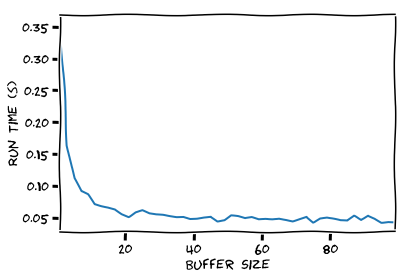

In [18]:
with plt.xkcd(scale=0.7):
    stopwatch.to_frame().query('setting == "pb buffered python scale"')\
        .groupby('buffer_size')['time']\
        .mean()\
        .reset_index()\
        .sort_values('buffer_size')\
        .plot('buffer_size', 'time', legend=None)
    plt.xlabel('Buffer Size')
    plt.ylabel('Run Time (s)')

Overhead goes down fairly fast with increasing buffer size, and very quickly stabilizes (remember: we generate 10000 events, so one could expect to get improvements up to that buffer size). The remaining overhead probably comes from conversion costs, and could be optimized further, for instance by making sure one only convert events that are of interest. This is a topic for another day.